# U.S. Medical Insurance Costs

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Exploración inicial de los datos

#### Carga de datos y resumen de estadísticas

In [18]:
df = pd.read_csv('insurance.csv')

print(df.head())

print(df.info())

print(df.describe(include = 'all'))

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
                age   sex          bmi     children smoker     region  \
count   1338.00000

#### Numero de nulos y duplicados

In [19]:
nulos = df.isnull().sum()
print(nulos)

duplicados = df.duplicated().sum()
print(f'Recursos duplicados {duplicados}')
print(df[df.duplicated(keep=False)])
print('Puede ser que dos personas compartan los mismos valores, solamente es 1 valor duplicado por lo que lo dejo')

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Recursos duplicados 1
     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631
Puede ser que dos personas compartan los mismos valores, solamente es 1 valor duplicado por lo que lo dejo


#### Conversión de datos pertinentes

Las columnas sex, smoker y region son categóricas, debo convertirlas en numéricas para obtener una mejor predicción

In [20]:
df['sex'] = df['sex'].map({'female': 1, 'male': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

df_encoded = pd.get_dummies(df, columns=['region'], drop_first=True)

#### Visualizar correlaciones entre las variables de dataset

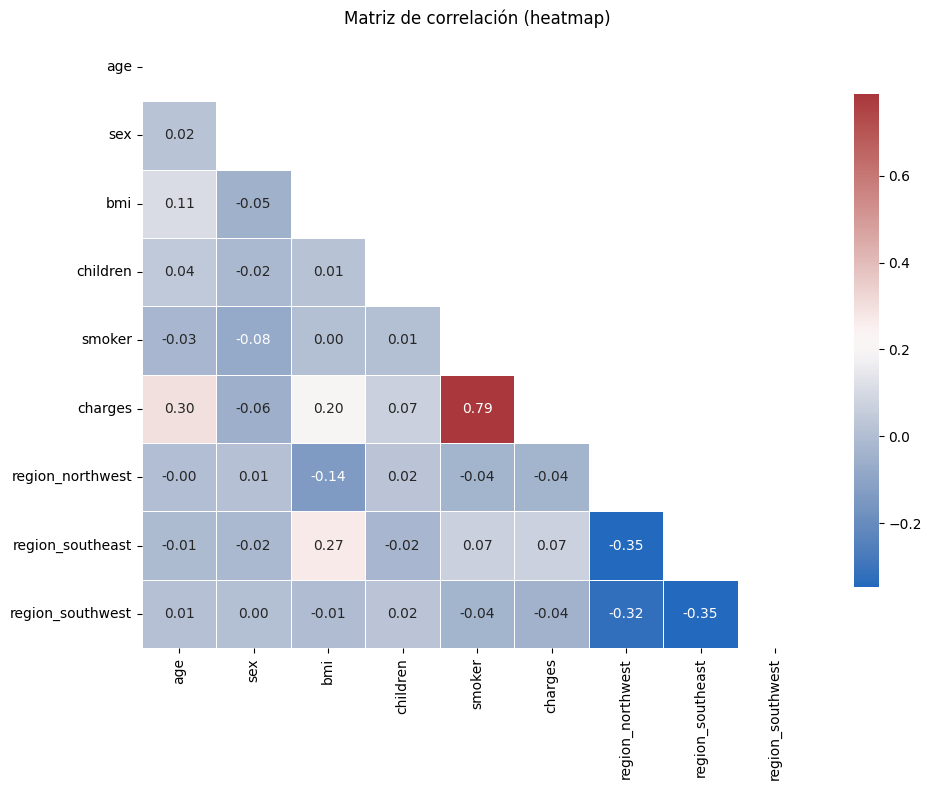

In [21]:
corr = df_encoded.corr()
plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(corr, dtype=bool)) 
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="vlag", linewidths=.5, cbar_kws={"shrink":.8})
plt.title("Matriz de correlación (heatmap)")
plt.tight_layout()
plt.show()

Claramente si fumas el costo es mucho más elevado, esto es muy importante de saber a la hora de preparar el modelo.
De hecho, se observan muchos outliers en la gente que no fuma, voy a sustituir estos outliers para obtener un modelo más preciso


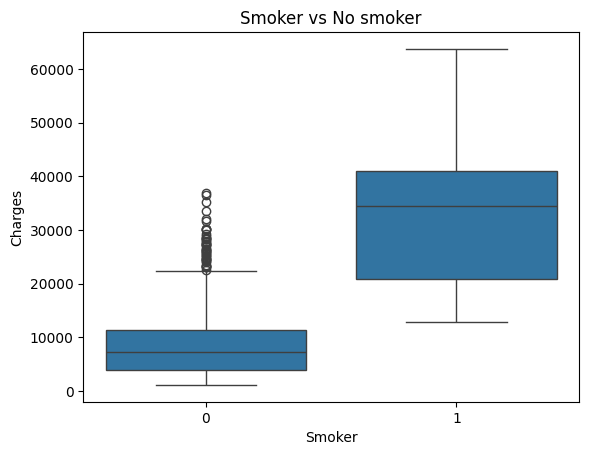

In [22]:
# ¿Las personas fumadoras pagan significativamente más que las no fumadoras?
sns.boxplot(df, x = 'smoker', y = 'charges')
plt.title('Smoker vs No smoker')
plt.ylabel('Charges')
plt.xlabel('Smoker')
plt.plot()

print('Claramente si fumas el costo es mucho más elevado, esto es muy importante de saber a la hora de preparar el modelo.')
print('De hecho, se observan muchos outliers en la gente que no fuma, voy a sustituir estos outliers para obtener un modelo más preciso')

Ahora ya no se observan outliers


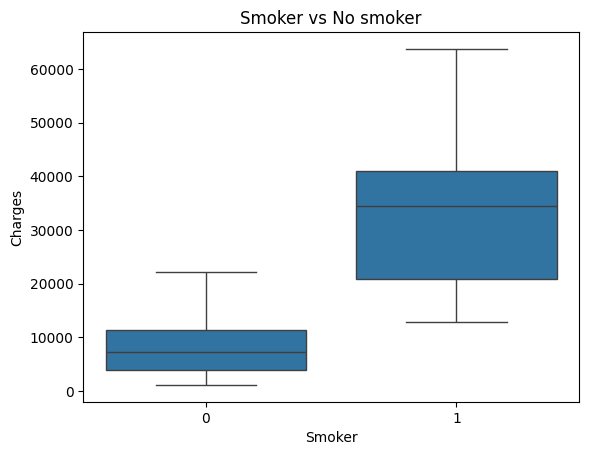

In [23]:
smoke_df = df[(df.charges > 22000) & (df.smoker == 0)]
min_smoke_df = smoke_df.charges.min()

df.loc[(df['charges'] > 22000) & (df['smoker'] == 0), 'charges'] = min_smoke_df

# Filtro el dataset para obtener todos los outliers y los sustituyo por el mínimo de este nuevo dataset
sns.boxplot(df, x = 'smoker', y = 'charges')
plt.title('Smoker vs No smoker')
plt.ylabel('Charges')
plt.xlabel('Smoker')
plt.plot()

print('Ahora ya no se observan outliers')

# 2. Planteamiento del problema
**Target = columna "charges" - predicir el costo del seguro**

La variable objetivo es una variable numérica por lo que se utilizará un modelo de regresión lineal para predecir el valor de la misma.


#### Selección de las variables predictoras (X) y variable objetivo (y)

In [24]:
y = df_encoded['charges']

x = df_encoded.drop(['charges'], axis = 1)

#### División del dataset en entrenamiento y prueba

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#### Escalado de datos

In [26]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Entreno del modelo

In [27]:
model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# 3. Evaluación del modelo

In [28]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE:  {mse}")
print(f"RMSE: {rmse}")
print(f"R²:   {r2}")

MSE:  33596915.851361476
RMSE: 5796.284659276274
R²:   0.7835929767120722


#### Función para predecir valores de charges con datos reales

In [29]:
def predecir_coste_seguro(age, sex, bmi, children, smoker, region):
    new_df = pd.DataFrame([{
        "age": age,
        "sex": sex,
        "bmi": bmi,
        "children": children,
        "smoker": smoker,
        "region_northwest": 1 if region == "northwest" else 0,
        "region_southeast": 1 if region == "southeast" else 0,
        "region_southwest": 1 if region == "southwest" else 0
    }])
    
    new_df_scaled = scaler.transform(new_df)

    pred = model.predict(new_df_scaled)
    return pred[0]

print(predecir_coste_seguro(23, 0, 24.86, 0, 0, 'southwest'))

1530.9519794139724


# 4. Conclusión

El modelo de regresión lineal desarrollado consigue explicar aproximadamente el 78% (R² = 0.78) de la variabilidad del coste del seguro médico, lo cual representa un rendimiento sólido y adecuado.

La variable con mayor impacto es, con mucha diferencia, si la persona fuma o no: ser fumador incrementa de manera significativa el coste del seguro. A esto le siguen el índice de masa corporal (BMI) y la edad, dos características que también muestran una correlación positiva con los gastos médicos. Otras variables como el sexo, el número de hijos o la región tienen influencia mucho menor.

El error medio (RMSE) ronda los 5.800 dólares, este valor es razonable considerando que los charges oscilan entre 2.000 y 60.000 dólares.

Para terminar, he creado una función en la que introducir tus datos y ver una predicción basada en datos reales.